In [1]:
%matplotlib inline

import torch
import pylab as plt
from munch import munchify
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from tqdm import tqdm
# from preprocessing.s02_create_dataset import load_cores_h5py

In [2]:
# project root
project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'

args = {}

# yaml configuration file location
args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
# experiment location to load
args['exp_suffix'] = '_Patch/lr1e-5_fr.4numgrad6----inv.7train.4test_res10_UVA400_new32_Isomax2'

# opt is a dictionary which contains all configurations
with open(args['config']) as f:
    opt = yaml.load(f, Loader)
opt.update(args)
opt = munchify(opt)
opt.project_root = project_root
opt = setup_directories(opt)

num_workers = 0
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# creating the neural network
net = construct_network(device, opt)
net = net[0]()

# loading the saved weights to it
suffix = '_1'
net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth'))

<All keys matched successfully>

In [8]:
# datafile to load the data. This cell and the next cell are just for having some sense of how to feed data.
# Please load your own data and make them similar to the shape of data in dataset.
data_file = '/'.join([opt.data_source.data_root, opt.data_source.test_set])
print('loading data...')
input_data = load_matlab(data_file)
print('loading done!')

loading data...
loading done!


In [9]:
from utils.dataset import create_datasets_test_Exact

initial_min_inv=.8
min_inv=.4

# which dataset to use for testset. Either train, val, or test
state = 'test'
dataset, core_len, true_involvement, patient_id_bk, gs_bk, roi_coors, true_labels, *ids = create_datasets_test_Exact(
    '/'.join([opt.data_source.data_root, opt.data_source.test_set]), dataset_name=opt.data_source.dataset,
    min_inv=min_inv, input_data=input_data, state=state, norm=opt.normalize_input)

cancer labels shape (1333, 2)
data shape (3483, 1, 256, 256)


In [10]:
# This function takes in net, device, and pair of (input, label, location) and produces output
# This is used in the next cell
def predict(net, input_data, input_label, device):
    from sklearn.metrics import confusion_matrix


    # location is not important here, so we make it up randomly
    input_location = torch.ones_like(input_label)

    outputs = []
    entropic_scores = []
    total = correct = 0
    cm = np.zeros((2,2))



    no_data = len(input_data)
    batch_size = 32
    no_batch = no_data//batch_size
    print('no batches and batch size:', no_batch, batch_size)
    # built-in function of class torch.utils.Dataset which sets model in evaluation mode
    # (here both evaluation and training are the same)
    net.eval()
    # apply model on test signals
    with torch.no_grad():
        for i in range(no_batch+1):
            strt = i*batch_size
            end = (i+1)*batch_size
            x_raw, y_batch, n_batch = input_data[strt:end,...], input_label[strt:end,...], input_location[strt:end,...]
            x_raw, y_batch, n_batch = x_raw.to(device), y_batch.to(device), n_batch.to(device)

            pred = net(x_raw, n_batch)
            pred = F.softmax(pred, dim=1)

            probabilities = pred  # torch.nn.Softmax(dim=1)(pred)
            entropies = -(probabilities * torch.log(probabilities)).sum(dim=1)
            entropic_scores.append((-entropies).cpu().numpy())

            outputs.append(pred.cpu().numpy())
            total += y_batch.size(0)
            correct += (pred.argmax(dim=1) == torch.argmax(y_batch, dim=1)).sum().item()
            cm += confusion_matrix(y_batch.argmax(dim=1).cpu(), pred.argmax(dim=1).cpu(), labels=[0,1])

    tn, fp, fn, tp = cm.ravel()
    acc_sb = (tp/(tp+fn) + tn/(tn+fp))/2.0
    outputs = np.concatenate(outputs)
    entropic_scores = np.concatenate(entropic_scores)
    return outputs, entropic_scores, correct / total, acc_sb

In [14]:
# these are input data and label corresponding to them
# label is just for plotts in the next cell, you can feed a random matrix of nx2 instead
x_data = dataset.tensors[0]
y_label = dataset.tensors[1]

predictions, ood_scores, acc_s, acc_sb = predict(net, x_data, y_label, device)

no batches and batch size: 108 32


              ACC_S  ACC_SB    AUC  AUPRC     F1    MCC   SEN   SPE    PRE  \
Epoch = Best  0.666   0.654  0.775  0.632  0.721  0.553  0.71  0.84  0.733   

               ACC  ACC_B   CORR     MAE  
Epoch = Best  0.79  0.775  0.565  22.546  


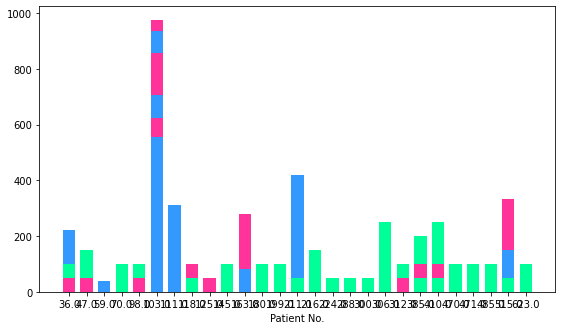

ValueError: Image size of 8722x207694 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

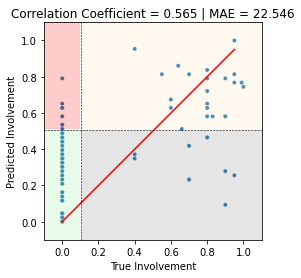

In [12]:
predicted_involvement, predicted_involvement2, ood, prediction_maps = infer_core_wise(predictions, core_len, roi_coors,
                                                                                      ood_scores)
scores = {'acc_s': acc_s, 'acc_sb': acc_sb}
scores = compute_metrics(predicted_involvement, true_involvement,
                         current_epoch=0, verbose=True, scores=scores,
                         threshold=0.5)

net_interpretation(predicted_involvement, predicted_involvement2, patient_id_bk,
                   true_involvement, gs_bk, opt.paths.result_dir,
                   ood=ood, current_epoch=0, set_name=state,
                   writer=False, scores=scores, threshold=0.5, plotting=True)